In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

In [4]:
PATH = "data/bulldozers/"

In [5]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw,'SalePrice')

In [6]:
def split_vals(a,n): return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn,n_trn)
y_train, y_valid = split_vals(y_trn,n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train),y_train), rmse(m.predict(X_valid), y_valid),
              m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print (res)

In [8]:
df_raw.describe(include='all')

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05,401125.000000,401125,...,401125.000000,401125.000000,401125.000000,401125,401125,401125,401125,401125,401125,4.011250e+05
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4999,...,NaN,NaN,NaN,2,2,2,2,2,1,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310G,...,NaN,NaN,NaN,False,False,False,False,False,False,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5039,...,NaN,NaN,NaN,387586,390968,394985,398606,401124,401125,NaN
mean,1.919713e+06,10.103096,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03,-0.623898,NaN,...,16.110402,2.600975,179.977581,NaN,NaN,NaN,NaN,NaN,NaN,1.091433e+09
std,9.090215e+05,0.693621,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04,0.870291,NaN,...,8.427322,1.405763,103.559930,NaN,NaN,NaN,NaN,NaN,NaN,1.816977e+08
min,1.139246e+06,8.465900,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,-1.000000,NaN,...,1.000000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.009984e+08
25%,1.418371e+06,9.581904,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00,-1.000000,NaN,...,9.000000,2.000000,84.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.708768e+08
50%,1.639422e+06,10.085809,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00,-1.000000,NaN,...,16.000000,3.000000,168.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.143072e+09
75%,2.242707e+06,10.596635,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03,-1.000000,NaN,...,23.000000,3.000000,271.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.237853e+09


In [9]:
set_rf_samples(50000)

In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20574275385656912, 0.2479023383939589, 0.91153246568593682, 0.89024881433330771, 0.8945660694113613]


In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.12 s, sys: 41.7 ms, total: 1.16 s
Wall time: 1.17 s


(9.1865069080954775, 0.22862061261792682)

In [12]:
def get_preds(t): return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m,get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 71.3 ms, sys: 68.4 ms, total: 140 ms
Wall time: 696 ms


(9.1865069080954775, 0.22862061261792682)

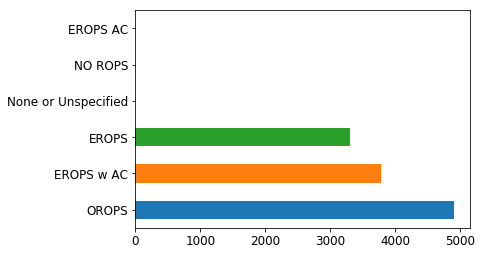

In [13]:
x= raw_valid.copy()
x['pred_std'] = np.std(preds,axis=0)
x['pred'] = np.mean(preds,axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure','SalePrice','pred','pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.840407,0.270303
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574736,0.266768
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.688773,0.220538


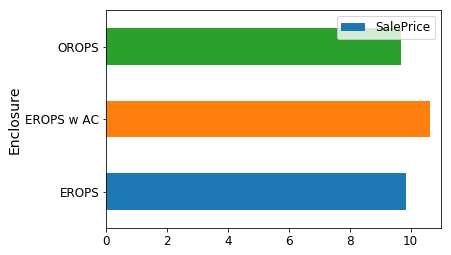

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure','SalePrice','barh', xlim=(0,11))

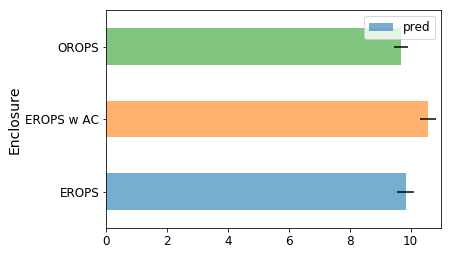

In [16]:
enc_summ.plot('Enclosure','pred','barh',xerr='pred_std',alpha=0.6,xlim=(0,11));

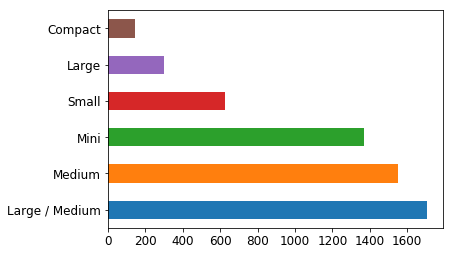

In [17]:
raw_valid.ProductSize.value_counts().plot.barh()

In [18]:
flds = ['ProductSize','SalePrice','pred','pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.845554,0.340944
Large,10.470589,10.390083,0.379348
Large / Medium,10.691871,10.647694,0.297590
Medium,10.681511,10.621858,0.285802
Mini,9.535147,9.555192,0.245214
Small,10.324448,10.339905,0.311319


In [19]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.036511
Compact           0.034629
Small             0.030108
Large / Medium    0.027949
Medium            0.026907
Mini              0.025663
dtype: float64

In [20]:
fi = rf_feat_importance(m,df_trn); fi[:10]

,cols,imp
5,YearMade,0.171343
37,Coupler_System,0.112995
13,ProductSize,0.104665
14,fiProductClassDesc,0.072900
2,ModelID,0.058550
63,saleElapsed,0.050902
10,fiSecondaryDesc,0.045417
39,Hydraulics_Flow,0.044049
19,Enclosure,0.036035
38,Grouser_Tracks,0.031002


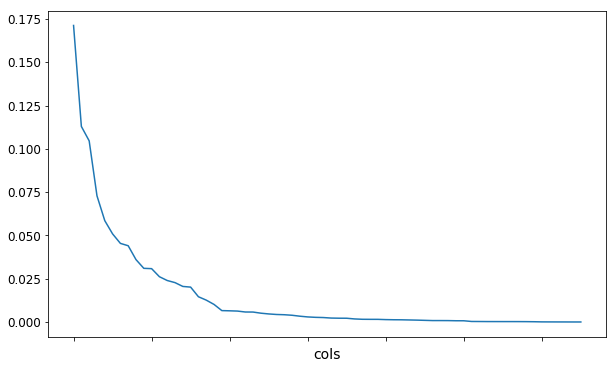

In [21]:
fi.plot('cols','imp', figsize=(10,6), legend=False)

In [22]:
def plot_fi(fi): return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)

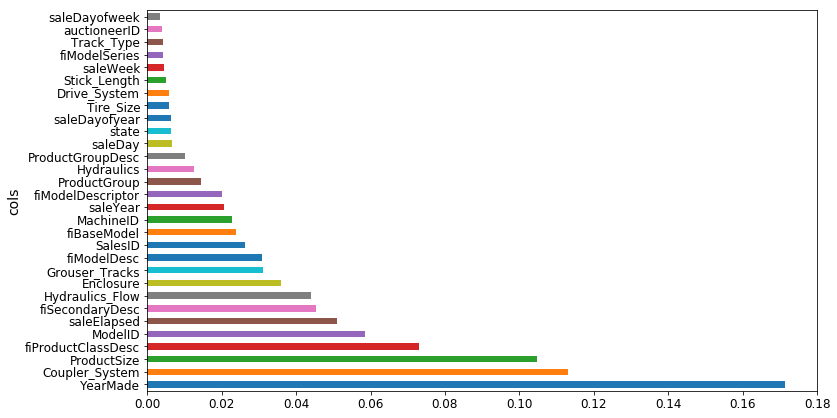

In [23]:
plot_fi(fi[:30]);

In [24]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [25]:
df_keep = df_trn[to_keep].copy()

In [26]:
X_train, X_valid = split_vals(df_keep, n_trn)

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                         n_jobs = -1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2070248394712326, 0.24599594032128022, 0.9104264597786168, 0.89193032287148899, 0.89411417929077497]


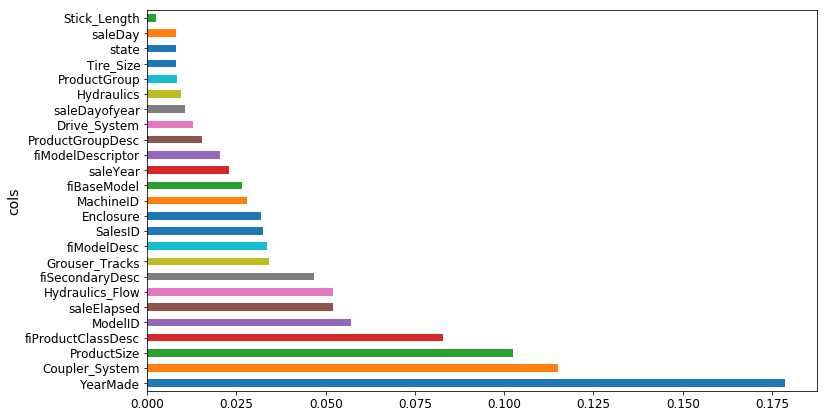

In [28]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [29]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat = 7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.6, n_jobs = -1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2076001853981917, 0.2535429862259632, 0.90992789754240821, 0.88519754476106571, 0.89216071419074761]


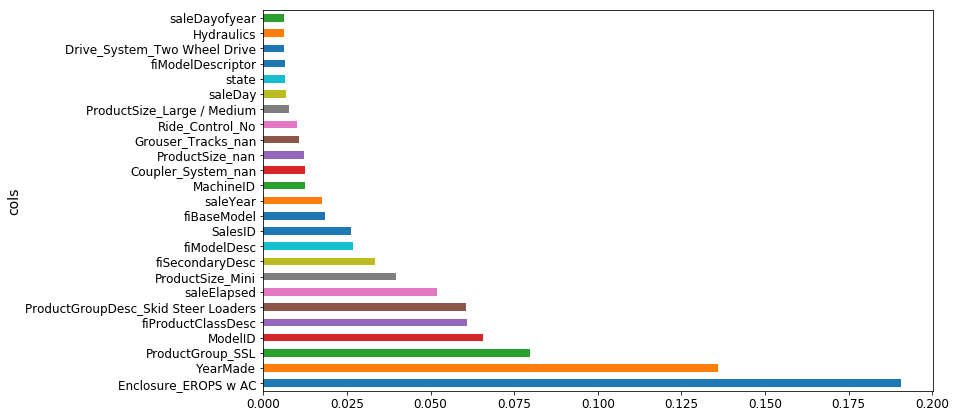

In [30]:
fi = rf_feat_importance(m,df_trn2)
plot_fi(fi[:25]);

In [31]:
from scipy.cluster import hierarchy as hc

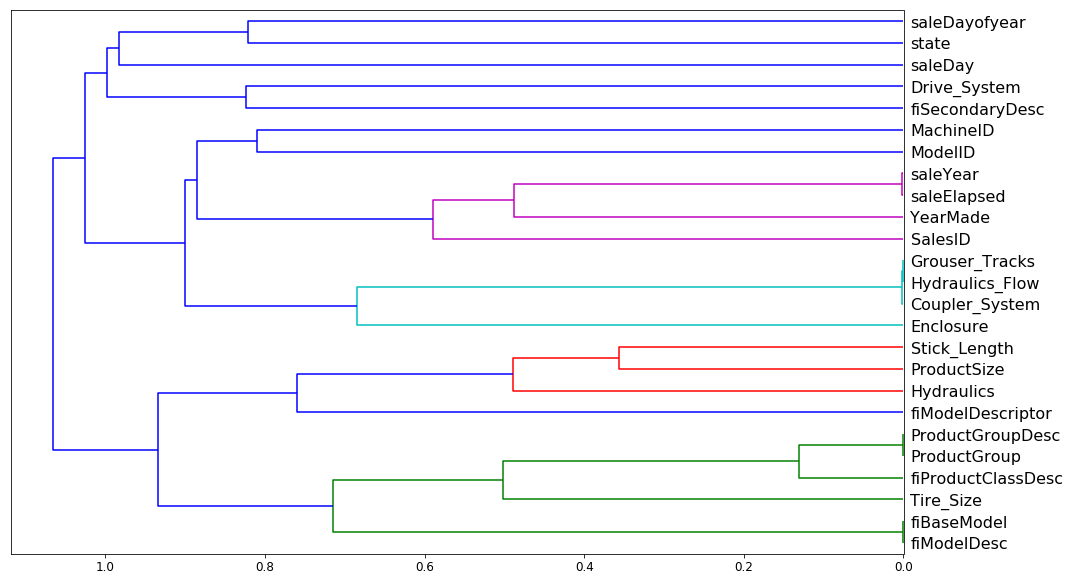

In [32]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed,method='average')
fig = plt.figure(figsize=(16,10))
dendogram = hc.dendrogram(z,labels=df_keep.columns, orientation='left',leaf_font_size=16)
plt.show()

In [33]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30,min_samples_leaf=5,max_features=0.6, n_jobs=-1,oob_score=True)
    x , _ = split_vals(df,n_trn)
    m.fit(x,y_train)
    return m.oob_score_

In [34]:
get_oob(df_keep)

0.89021171621096429

In [35]:
for c in ('saleYear','saleElapsed','fiModelDesc','fiBaseModel','Grouser_Tracks','Coupler_System'):
    print(c, get_oob(df_keep.drop(c,axis=1)))

saleYear 0.889110242984
saleElapsed 0.88614578174
fiModelDesc 0.888465523806
fiBaseModel 0.88991895134
Grouser_Tracks 0.890355899008
Coupler_System 0.890479630841


In [36]:
to_drop = ['saleYear','fiBaseModel','Grouser_Tracks']
get_oob(df_keep.drop(to_drop,axis=1))

0.88896284649093249

In [37]:
df_keep.drop(to_drop,axis=1,inplace=True)
X_train, X_valid = split_vals(df_keep,n_trn)

In [38]:
np.save('tmp/keep_cols.npy',np.array(df_keep.columns))

In [39]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [40]:
reset_rf_samples()

In [41]:
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.5,n_jobs=-1,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.1248711225227563, 0.2269125160378781, 0.96741191370351598, 0.90804721726014592, 0.90872971900370303]


In [42]:
from pdpbox import pdp
# import scipy.stats
from plotnine import *

In [43]:
set_rf_samples(50000)

In [44]:
df_trn2, y_trn, nas = proc_df(df_raw,'SalePrice',max_n_cat=7)
X_train, X_valid = split_vals(df_trn2,n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6,n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.6, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

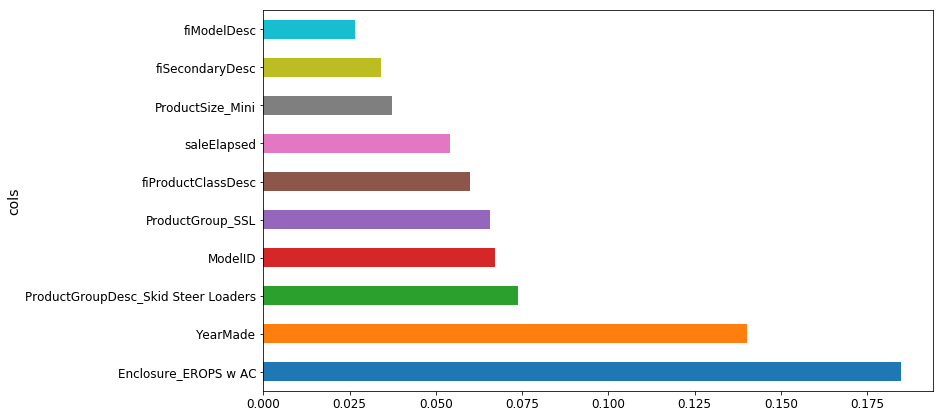

In [45]:
plot_fi(rf_feat_importance(m,df_trn2)[:10]);

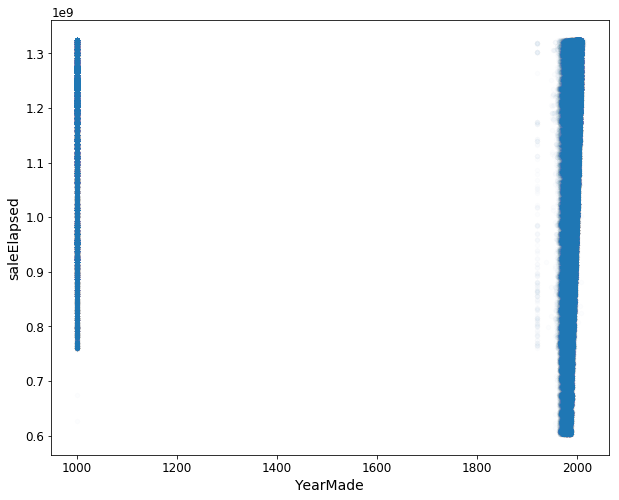

In [46]:
df_raw.plot('YearMade','saleElapsed','scatter', alpha=0.01, figsize=(10,8));

In [47]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [48]:
ggplot(x_all, aes('YearMade','SalePrice')) + stat_smooth(se=True, method='loess')

PlotnineError: "For loess smoothing, install 'scikit-misc'"

In [49]:
x = get_sample(X_train[X_train.YearMade>1930],500)

In [50]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m,x,feat)
    return pdp.pdp_plot(p,feat_name,plot_lines=True,
                       cluster=clusters is not None, n_cluster_centers=clusters)

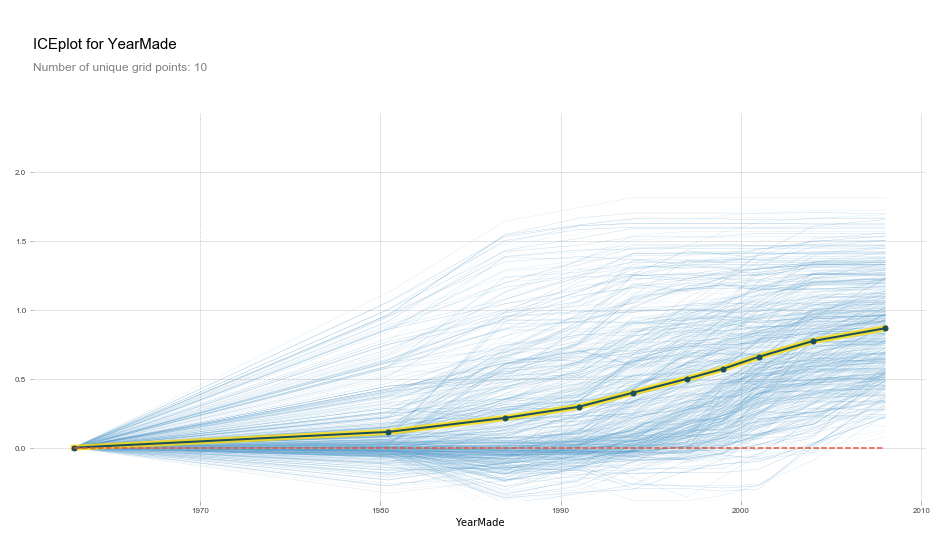

In [51]:
plot_pdp('YearMade')

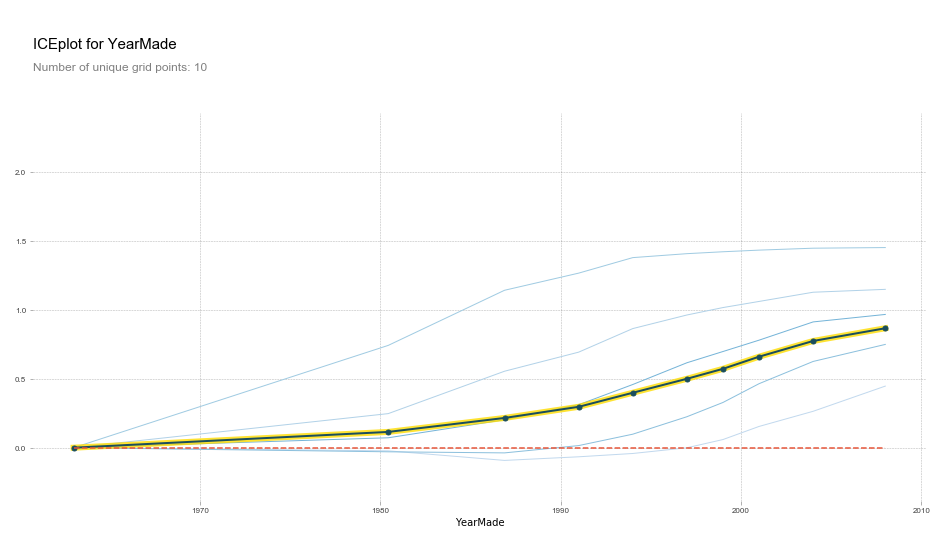

In [52]:
plot_pdp('YearMade', clusters=5)

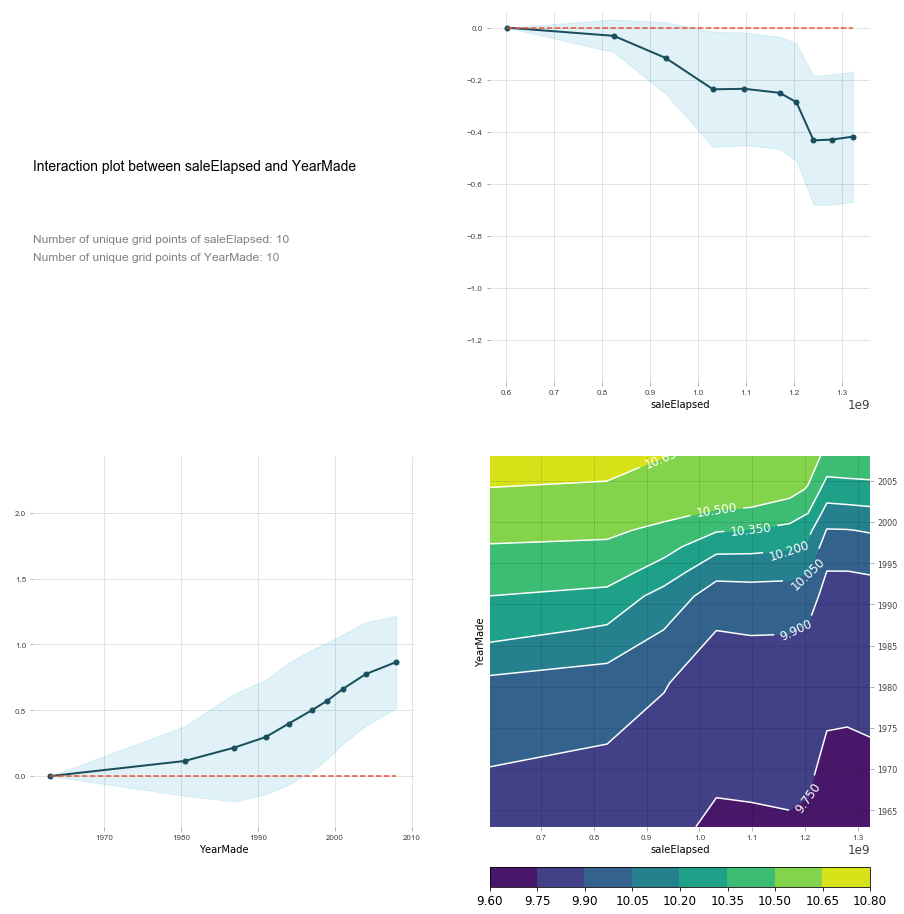

In [53]:
feats = ['saleElapsed','YearMade']
p = pdp.pdp_interact(m,x,feats)
pdp.pdp_interact_plot(p,feats)

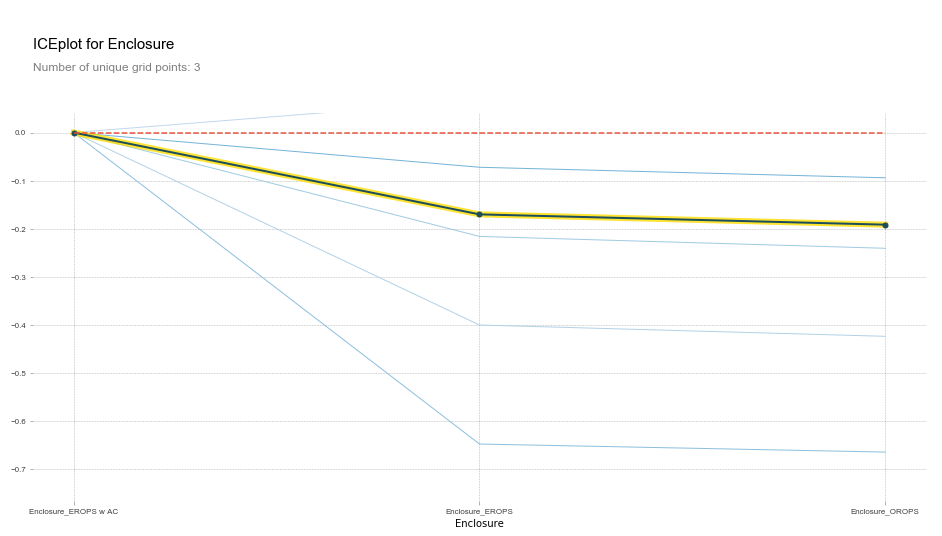

In [54]:
plot_pdp(['Enclosure_EROPS w AC','Enclosure_EROPS','Enclosure_OROPS'],5,'Enclosure')

In [55]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear - df_raw.YearMade

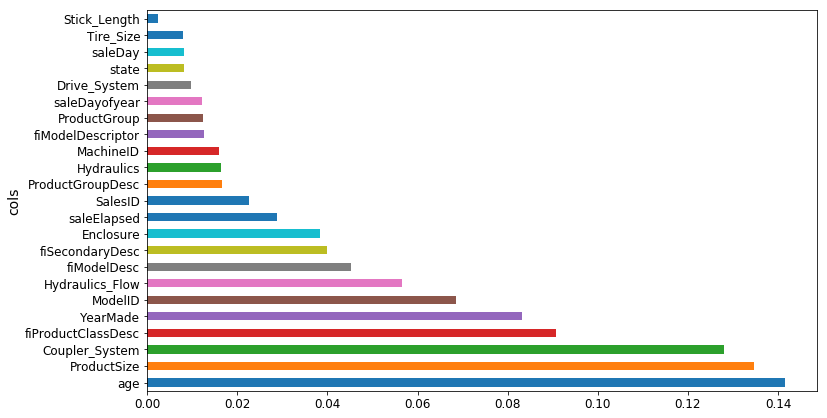

In [56]:
X_train, X_valid = split_vals(df_keep,n_trn)
m = RandomForestRegressor(n_estimators=40,min_samples_leaf=3,max_features=0.6,n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m,df_keep))

In [58]:
from treeinterpreter import treeinterpreter as ti

In [59]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [60]:
row  = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665, 1284595200,          0,          0,
                 1,       3232,    4364751,    2300944,          0,          4,         12,          4,
                16,         35,        259,          0,          0,         29,         11]])

In [61]:
prediction, bias, contributions = ti.predict(m,row)

In [62]:
prediction[0], bias[0]

(9.3655813439639637, 10.10488617787826)

In [63]:
idxs = np.argsort(contributions[0])

In [64]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5626512248370501),
 ('age', 11, -0.11449955325848626),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.11244591462863171),
 ('Enclosure', 'EROPS', -0.057892353551900831),
 ('fiSecondaryDesc', nan, -0.055896125959019959),
 ('fiModelDesc', 'KX1212', -0.038345572640556248),
 ('SalesID', 4364751, -0.032262538491326834),
 ('fiModelDescriptor', nan, -0.01703436410994974),
 ('saleDayofyear', 259, -0.014809493759038395),
 ('Tire_Size', nan, -0.0072482105708847385),
 ('saleDay', 16, -0.005191473322949669),
 ('state', 'Ohio', -0.0017619316071736169),
 ('Stick_Length', 'None or Unspecified', 0.0),
 ('Drive_System', nan, 0.0052732849362095548),
 ('ProductGroup', 'TEX', 0.0072147853502377403),
 ('ProductGroupDesc', 'Track Excavators', 0.011749805038263884),
 ('saleElapsed', 1284595200, 0.019420496340558334),
 ('Hydraulics', 'Standard', 0.021316844442185269),
 ('Hydraulics_Flow', nan, 0.023733554328619587),
 ('MachineID', 2300944, 0.0

In [65]:
contributions[0].sum()

-0.73930483391429636

In [66]:
df_ext = df_keep.copy()
df_ext['is_valid']=1
df_ext.is_valid[:n_trn] = 0
x,y,nas = proc_df(df_ext, 'is_valid')

In [67]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x,y);
m.oob_score_

0.99972057304382345

In [68]:
fi = rf_feat_importance(m,x); fi[:10]

,cols,imp
10,SalesID,0.801278
5,saleElapsed,0.111915
11,MachineID,0.071341
18,saleDayofyear,0.005489
9,fiModelDesc,0.002695
4,ModelID,0.002339
0,YearMade,0.001404
6,fiSecondaryDesc,0.000994
22,age,0.000888
1,Coupler_System,0.000708


In [69]:
feats = ['SalesID','saleElapsed','MachineID']

In [70]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [71]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [72]:
x.drop(feats, axis=1, inplace=True)

In [73]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x,y);
m.oob_score_

0.5145110927265667

In [74]:
fi = rf_feat_importance(m,x); fi[:10]

,cols,imp
19,age,0.234316
0,YearMade,0.188921
15,saleDayofyear,0.159151
4,ModelID,0.076276
8,fiModelDesc,0.059782
13,saleDay,0.056915
14,state,0.055986
3,fiProductClassDesc,0.031318
5,fiSecondaryDesc,0.024049
7,Enclosure,0.021491


In [75]:
set_rf_samples(50000)

In [76]:
feats = ['SalesID','saleElapsed','MachineID','age','YearMade','saleDayofyear']

In [77]:
X_train, X_valid = split_vals(df_keep,n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.20833397738748433, 0.24750379804910128, 0.90929002723699148, 0.89060141379749291, 0.89272570375387161]


In [78]:
for f in feats:
    df_subs = df_keep.drop(f,axis=1)
    X_train, X_valid = split_vals(df_subs,n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train,y_train)
    print(f)
    print_score(m)

SalesID
[0.20908601236851404, 0.24648046576848592, 0.9086339633820002, 0.89150418513579643, 0.89227911468281373]
saleElapsed
[0.2140273951462689, 0.25540014106707976, 0.90426437919940172, 0.88350957235482619, 0.88705889626656731]
MachineID
[0.2067381185781029, 0.2450324185731914, 0.91067439930937233, 0.89277524380632356, 0.8949329969575488]
age
[0.20878865485494524, 0.2478202335735001, 0.90889365610876194, 0.89032150109553987, 0.89227272180220996]
YearMade
[0.2085059144783175, 0.25168031774556, 0.90914024039141783, 0.88687815464838271, 0.89251687528210055]
saleDayofyear
[0.20875824807186796, 0.2439897867736965, 0.90892019058800222, 0.89368580160912137, 0.89275961200861742]


In [79]:
reset_rf_samples()

In [80]:
df_subs = df_keep.drop(['SalesID','MachineID','saleDayofyear'],axis=1)
X_train, X_valid = split_vals(df_subs,n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train,y_train)
print_score(m)

[0.13740947428739367, 0.21890720460667126, 0.96053899132414367, 0.91442082719861939, 0.90905646638835569]


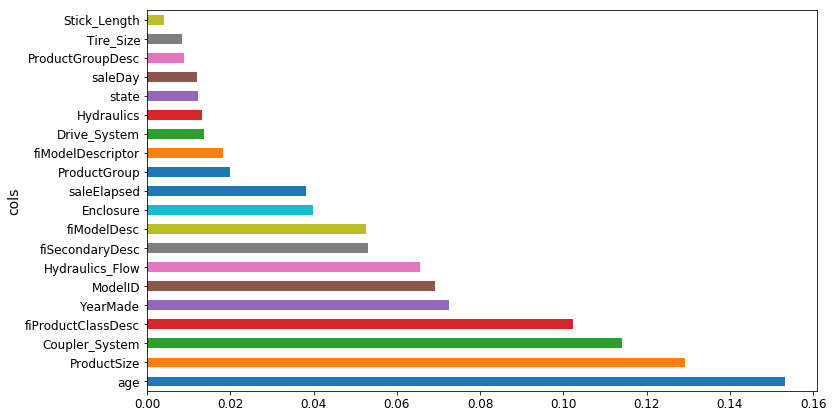

In [82]:
plot_fi(rf_feat_importance(m,X_train));

In [83]:
np.save('tmp/subs_cols.npy',np.array(df_subs.columns))

In [84]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train,y_train)
print_score(m)

CPU times: user 4min 22s, sys: 9.45 s, total: 4min 32s
Wall time: 1min 34s
[0.0799788123706423, 0.2117160003498329, 0.98663143697502942, 0.91995110601505248, 0.91464060075952003]
